# Prédiction des Risques de Maladies Cardiaques via Machine Learning

**Auteurs :** Mahfoud Houmad - Mondir Ayoub - Redouane Hakim  
**Date :** 5 Décembre 2025  
**Contexte :** Projet de machine learning dans le cadre du module d'Intelligence Artificielle.

## 1. Introduction & Contexte Business

###  L'Objectif
Les maladies cardiovasculaires sont la première cause de mortalité dans le monde. L'objectif de ce projet est de développer un outil d'aide à la décision pour les professionnels de santé. En analysant des données médicales standards (âge, cholestérol, tension...), nous cherchons à prédire le risque qu'un patient développe une maladie cardiaque.  

###  Les Données
Nous utilisons les données issues de l'enquête **NHANES** (National Health and Nutrition Examination Survey) du CDC américain.(voici le lien: https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Cycle=2017-2018). Il s'agit de données réelles, non nettoyées, ce qui nous permet de simuler un vrai cas d'usage professionnel.  
Le dataset final regroupe aussi la dataset **Cardiovascular Disease dataset** depuis kaggle (voici le lien : https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) afin d'ameliorer le nombre de personne pour notre modèle  

###  La Démarche
Notre approche suit le pipeline standard de la Data Science :
1.  **Acquisition et Nettoyage des Données :** Fusion des sources et nettoyage rigoureux (gestion des valeurs manquantes, encodage).
2.  **Exploration de données :** Compréhension des facteurs de risques.
3.  **Modélisation Avancée :** Comparaison d'algorithmes.
4.  **Mise en Production :** Simulation d'un outil de diagnostic pour de nouveaux patients.

## 2. Configuration de l'Environnement (Setup)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Outils de Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métriques
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve
)

# Ignorer les warnings inutiles
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Environnement chargé avec succès.")

Environnement chargé avec succès.


## 3. Acquisition et Nettoyage des Données

Cette section est dédiée à l'ingénierie des données : charger les multiples fichiers bruts , les fusionner, et appliquer les règles de nettoyage pour obtenir un dataset fiable à 100% pour la modélisation.

LA dataset de Nhanes:

In [21]:
# IMPORTATION & FUSION
def load_data():
    try:
        # Chargement
        print("Chargement des fichiers XPT")
        demo  = pd.read_sas('data/DEMO_J.XPT')
        diab  = pd.read_sas('data/DIQ_J.XPT')
        smoke = pd.read_sas('data/SMQ_J.XPT')
        chol  = pd.read_sas('data/TCHOL_J.XPT')
        bp    = pd.read_sas('data/BPX_J.XPT')
        med   = pd.read_sas('data/MCQ_J.XPT')


        # Fusion (Inner Join sur SEQN)
        df = pd.merge(demo, diab,  on='SEQN')
        df = pd.merge(df, smoke,   on='SEQN')
        df = pd.merge(df, chol,    on='SEQN')
        df = pd.merge(df, bp,      on='SEQN')
        df = pd.merge(df, med,     on='SEQN')
        

        print(f"Données fusionnées : {df.shape[0]} lignes, {df.shape[1]} colonnes.")
        return df
    except Exception as e:
        print(f"Erreur : {e}")
        return None

df_raw = load_data()

Chargement des fichiers XPT
Données fusionnées : 6401 lignes, 232 colonnes.


In [22]:
# SÉLECTION & VALEURS CACHÉES

# 1. Sélection des variables utiles
cols_utiles = {
    'SEQN': 'ID',
    'RIAGENDR': 'Sexe',
    'RIDAGEYR': 'Age',
    'LBXTC': 'Cholesterol',
    'BPXSY1': 'Tension',
    'DIQ010': 'Diabete',
    'SMQ020': 'Fumeur'
}
df = df_raw[list(cols_utiles.keys()) + ['MCQ160E', 'MCQ160C']].rename(columns=cols_utiles)

# 2. Création de la Cible (Target)
df['HeartDisease'] = ((df['MCQ160E'] == 1) | (df['MCQ160C'] == 1)).astype(int)
df.drop(columns=['MCQ160E', 'MCQ160C'], inplace=True)

print("\n--- POURCENTAGE DE MANQUANTS ---")
nan_percentage = (df.isna().sum() / len(df)) * 100
print(nan_percentage)


--- POURCENTAGE DE MANQUANTS ---
ID               0.000000
Sexe             0.000000
Age              0.000000
Cholesterol      7.311358
Tension         11.341978
Diabete          0.000000
Fumeur          13.560381
HeartDisease     0.000000
dtype: float64


In [23]:
# 3. Traitement des "Valeurs Cachées"
for col in ['Diabete', 'Fumeur', 'Sexe']:
    df[col] = df[col].replace({7: np.nan, 9: np.nan, 3: np.nan})

# 4. Bilan des manquants
print("\nValeurs manquantes après nettoyage des codes cachés :")
print(df.isna().sum())

# 5. Suppression (Drop)
df_clean = df.dropna().copy()
print(f"Données propres restantes : {df_clean.shape[0]} patients")

# 6. Encodage binaire clair (1 = Oui/Homme, 0 = Non/Femme)
binary_map = {1: 1, 2: 0}
for col in ["Sexe", "Diabete", "Fumeur"]:
    df_clean[col] = df_clean[col].map(binary_map)

print("\nAperçu encodage binaire :")
print(df_clean[["Sexe", "Diabete", "Fumeur"]].head())



Valeurs manquantes après nettoyage des codes cachés :
ID                0
Sexe              0
Age               0
Cholesterol     468
Tension         726
Diabete         177
Fumeur          868
HeartDisease      0
dtype: int64
Données propres restantes : 4449 patients

Aperçu encodage binaire :
   Sexe  Diabete  Fumeur
1     1        0       0
4     0        0       1
5     1        0       0
6     1        0       1
7     1        0       1


In [24]:
# 7 Catégorisation du Cholestérol

conditions = [
    (df_clean['Cholesterol'] <= 200),
    (df_clean['Cholesterol'] > 200) & (df_clean['Cholesterol'] < 240),
    (df_clean['Cholesterol'] >= 240)
]
choices = ['1','2','3']

df_clean['Cholesterol'] = np.select(conditions, choices, default=np.nan)

In [25]:
# DÉTECTION & TRAITEMENT SIMPLE DES VALEURS ABERRANTES 

print("Quantiles Age :")
print(df_clean["Age"].describe(percentiles=[0.01, 0.99]))

print("\nQuantiles Tension :")
print(df_clean["Tension"].describe(percentiles=[0.01, 0.99]))



# Clipping 1% - 99%
for col in ["Age", "Tension"]:
    low = df_clean[col].quantile(0.01)
    high = df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lower=low, upper=high)

print("\n Valeurs extrêmes limitées (clipping 1% - 99%).")

Quantiles Age :
count    4449.000000
mean       49.510677
std        18.644594
min        18.000000
1%         18.000000
50%        51.000000
99%        80.000000
max        80.000000
Name: Age, dtype: float64

Quantiles Tension :
count    4449.000000
mean      125.676781
std        19.384059
min        78.000000
1%         94.000000
50%       124.000000
99%       186.000000
max       228.000000
Name: Tension, dtype: float64

 Valeurs extrêmes limitées (clipping 1% - 99%).


LA dataset Cardiovascular Disease dataset :

In [26]:
db2  = pd.read_csv('data/cardio_train.csv' , sep=';')
db2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


L'adaptation du data de Kaggle dataset avant le merge

In [27]:
# Age en années
db2['age'] = db2['age'] // 365

# Suppression des colonnes inutiles
db2.drop(columns=['alco', 'ap_lo','height' , 'weight' ,'id', 'active'], inplace=True)

# Renommage des colonnes
db2 = db2.rename(columns={'ap_hi': 'Tension',
                    'gluc': 'Diabete' , 
                    'smoke': 'Fumeur' ,
                    'age': 'Age' ,
                    'cholesterol': 'Cholesterol' ,
                    'cardio': 'HeartDisease',
                    'gender': 'Sexe'
                    })

# Encodage Sexe (1 = Oui/Homme, 0 = Non/Femme)
db2['Sexe'] = db2['Sexe'].map({1: 1, 2: 0})  

# encodage Diabete (1 = Oui, 0 = Non)
db2['Diabete'] = db2['Diabete'].map({1: 0 , 2: 0 , 3: 1})

# type conversion pour Tension
db2['Tension'].astype(float)

#pas de valeurs manquantes
db2.isna().sum()

Age             0
Sexe            0
Tension         0
Cholesterol     0
Diabete         0
Fumeur          0
HeartDisease    0
dtype: int64

Fusionner les deux datasets :


In [28]:
df_clean = pd.concat([df_clean, db2], ignore_index=True)
df_clean.drop(columns=['ID'], inplace=True)
df_clean.isna().sum()

Sexe            0
Age             0
Cholesterol     0
Tension         0
Diabete         0
Fumeur          0
HeartDisease    0
dtype: int64

In [29]:
print(df_clean.shape)
df_clean.head()

(74449, 7)


,Sexe,Age,Cholesterol,Tension,Diabete,Fumeur,HeartDisease
0,1,18.0,1,112.0,0,0,0
1,0,75.0,1,120.0,0,1,0
2,1,56.0,2,108.0,0,0,0
3,1,18.0,1,112.0,0,1,0
4,1,67.0,1,104.0,0,1,0


## 4.Exploration des données 

la Matrice de correlation

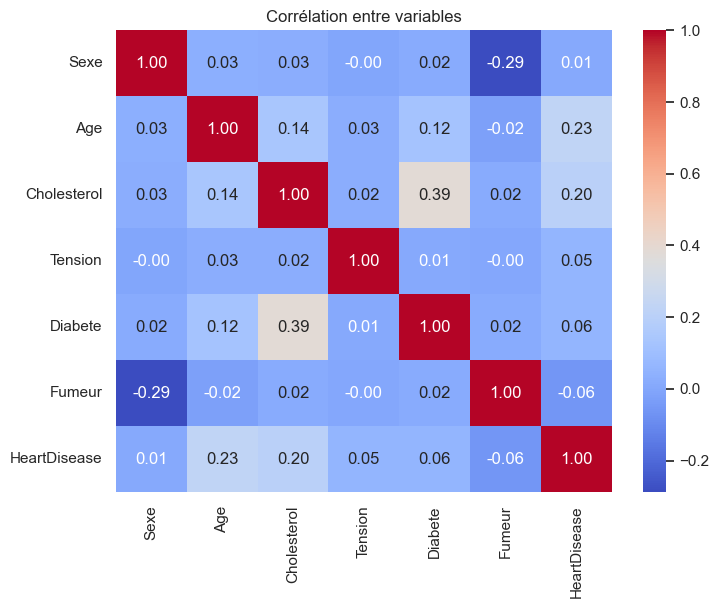

In [30]:
plt.figure(figsize=(8, 6))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Corrélation entre variables")
plt.show()

Distribution de l'âge

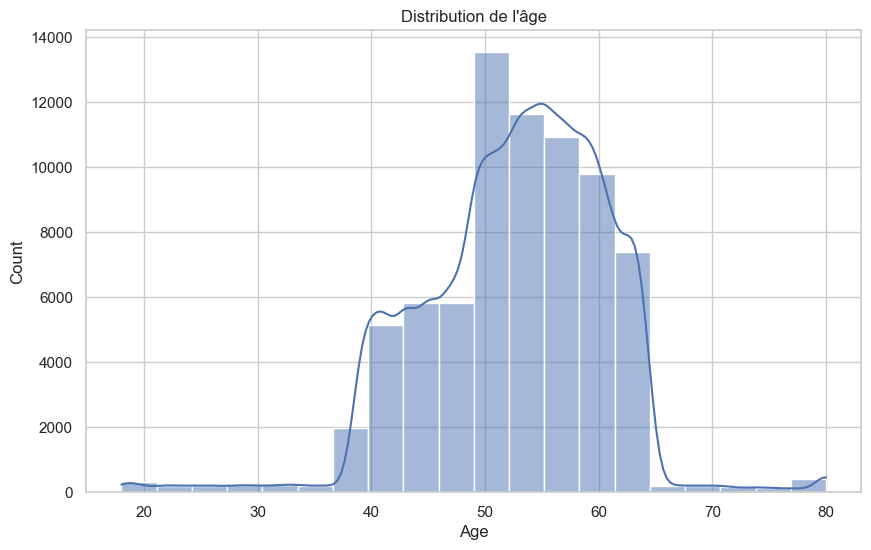

In [31]:
# Distribution de l'âge
plt.figure()
sns.histplot(df_clean["Age"], bins=20, kde=True)
plt.title("Distribution de l'âge")
plt.show()


 Distribution du cholestérol

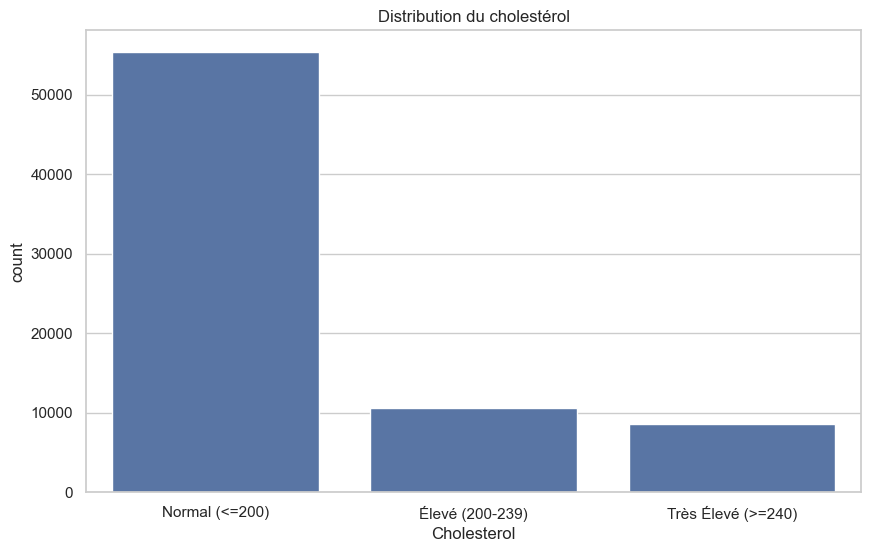

In [38]:

# Distribution du cholestérol
plt.figure()
ax = sns.countplot(x= df_clean["Cholesterol"])
ax.set_xticklabels(['Normal (<=200)', 'Élevé (200-239)', 'Très Élevé (>=240)'])
plt.title("Distribution du cholestérol")
plt.show()


cholesterol avec Maladie cardiaque

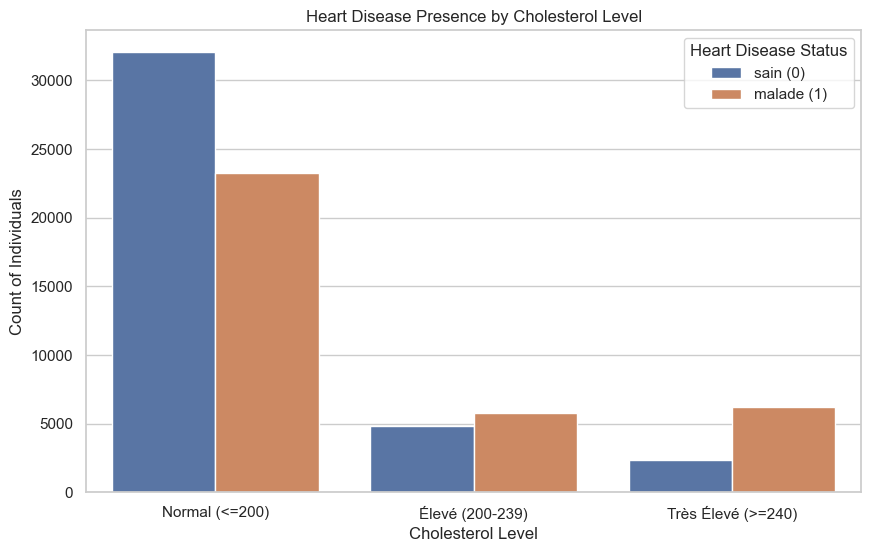

In [ ]:
# cholesterol avec Maladie cardiaque
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    x='Cholesterol', 
    hue='HeartDisease', 
    data=df_clean,
)
ax.set_xticklabels(['Normal (<=200)', 'Élevé (200-239)', 'Très Élevé (>=240)'])
plt.title("Heart Disease avec Cholesterol ")
plt.xlabel("Cholesterol ")
plt.ylabel("nombres de personnes")
plt.legend(title="Heart Disease Status", labels=['sain (0)', 'malade (1)'])
plt.show()

diabete avec Maladie cardiaque

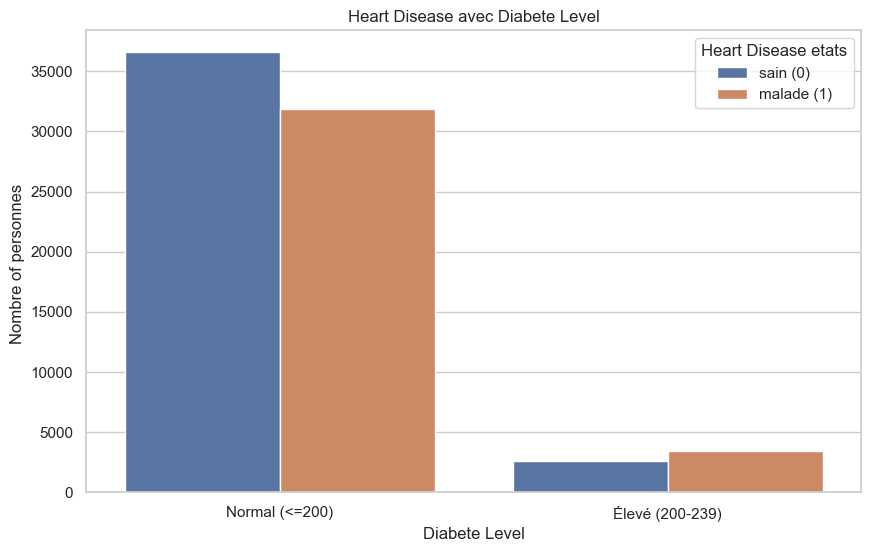

In [48]:
# diabete avec Maladie cardiaque
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    x='Diabete', 
    hue='HeartDisease', 
    data=df_clean,
)
ax.set_xticklabels(['Normal (<=200)', 'Élevé (200-239)', 'Très Élevé (>=240)'])
plt.title("Heart Disease avec Diabete Level")
plt.xlabel("Diabete Level")
plt.ylabel("Nombre of personnes ")
plt.legend(title="Heart Disease etats", labels=['sain (0)', 'malade (1)'])
plt.show()

# 5.Modélisation Avancée

Découpage train/test 

In [51]:
features = ["Age", "Cholesterol", "Tension", "Diabete", "Fumeur", "Sexe"]
X = df_clean[features]
y = df_clean["HeartDisease"]

# Découpage train/test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Distribution de la cible dans y_train :")
print(y_train.value_counts(normalize=True))

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Données standardisées prêtes pour les modèles.")

Distribution de la cible dans y_train :
HeartDisease
0    0.527292
1    0.472708
Name: proportion, dtype: float64
Données standardisées prêtes pour les modèles.


Le model Regression logistique 

=== LOGISTIC REGRESSION - Seuil 0.5 ===
Accuracy : 0.7053055742108798
Recall (classe 1) : 0.6178370786516854
ROC-AUC : 0.7699319172704004

Classification report :
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      7770
           1       0.73      0.62      0.67      7120

    accuracy                           0.71     14890
   macro avg       0.71      0.70      0.70     14890
weighted avg       0.71      0.71      0.70     14890



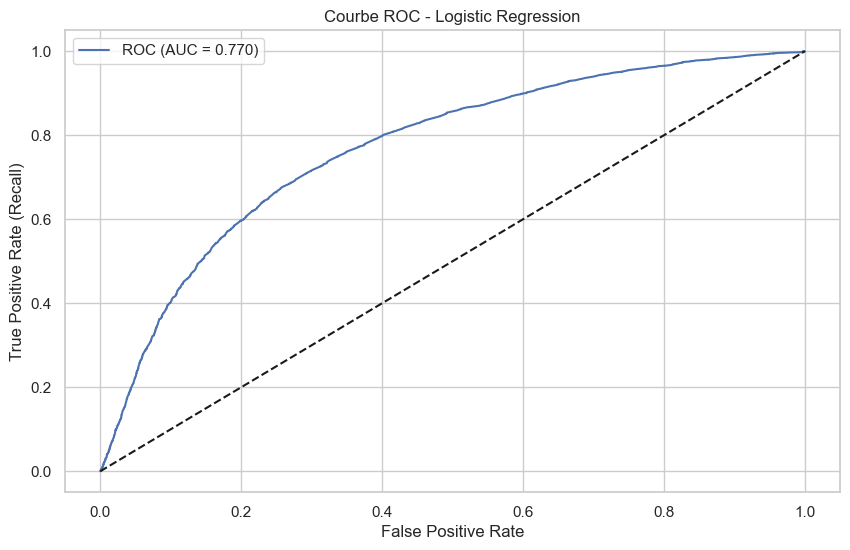

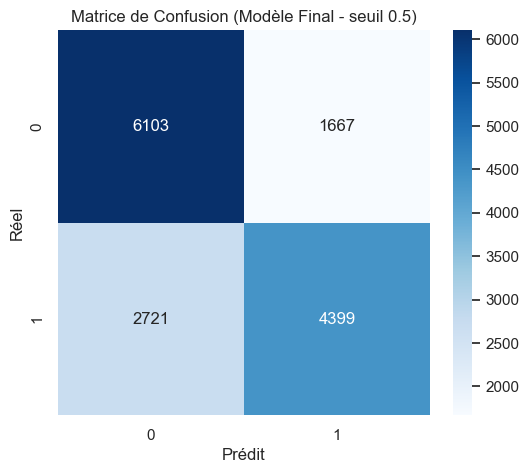

In [57]:
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000
)

log_reg.fit(X_train_scaled, y_train)

# 1) Prédictions avec seuil 0.5
y_pred_05 = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("=== LOGISTIC REGRESSION - Seuil 0.5 ===")
print("Accuracy :", accuracy_score(y_test, y_pred_05))
print("Recall (classe 1) :", recall_score(y_test, y_pred_05, pos_label=1))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))
print("\nClassification report :")
print(classification_report(y_test, y_pred_05))

# 2) Courbe ROC
fpr, tpr, roc_thr = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Courbe ROC - Logistic Regression")
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_05),
            annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion (Modèle Final - seuil 0.5)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()




Le model Random Forêst 

=== RANDOM FOREST - Seuil 0.5 ===
Accuracy : 0.7347212894560108
Recall (classe 1) : 0.6933988764044944
ROC-AUC : 0.7982119720041068

Classification report :
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      7770
           1       0.74      0.69      0.71      7120

    accuracy                           0.73     14890
   macro avg       0.73      0.73      0.73     14890
weighted avg       0.73      0.73      0.73     14890



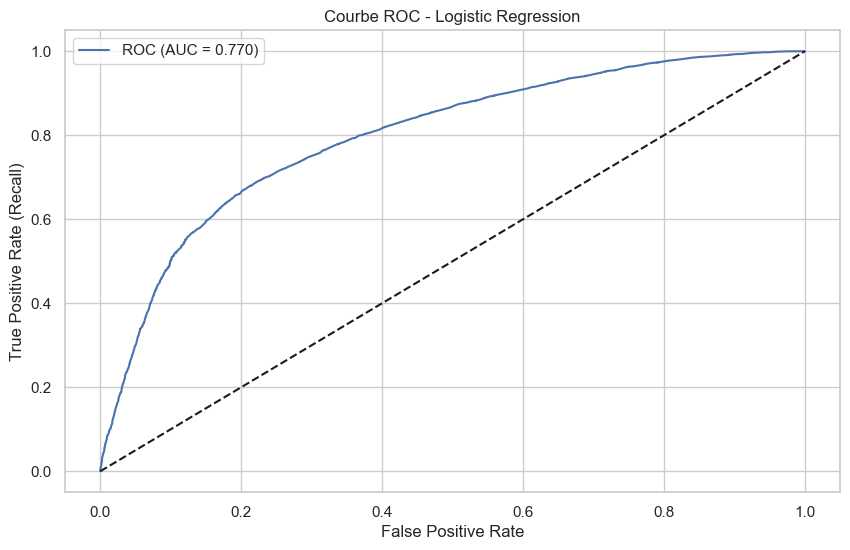

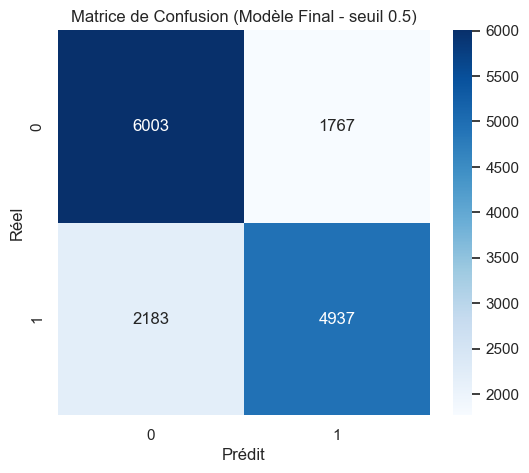

In [58]:

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("=== RANDOM FOREST - Seuil 0.5 ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Recall (classe 1) :", recall_score(y_test, y_pred_rf, pos_label=1))
print("ROC-AUC :", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report :")
print(classification_report(y_test, y_pred_rf))

fpr, tpr, roc_thr = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Courbe ROC - Logistic Regression")
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion (Modèle Final - seuil 0.5)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()






Le model XG Boost

=== XGBOOST - Seuil 0.5 ===
Accuracy : 0.7360644728005373
Recall (classe 1) : 0.677247191011236
ROC-AUC : 0.8021658225239685

Classification report :
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      7770
           1       0.75      0.68      0.71      7120

    accuracy                           0.74     14890
   macro avg       0.74      0.73      0.73     14890
weighted avg       0.74      0.74      0.74     14890



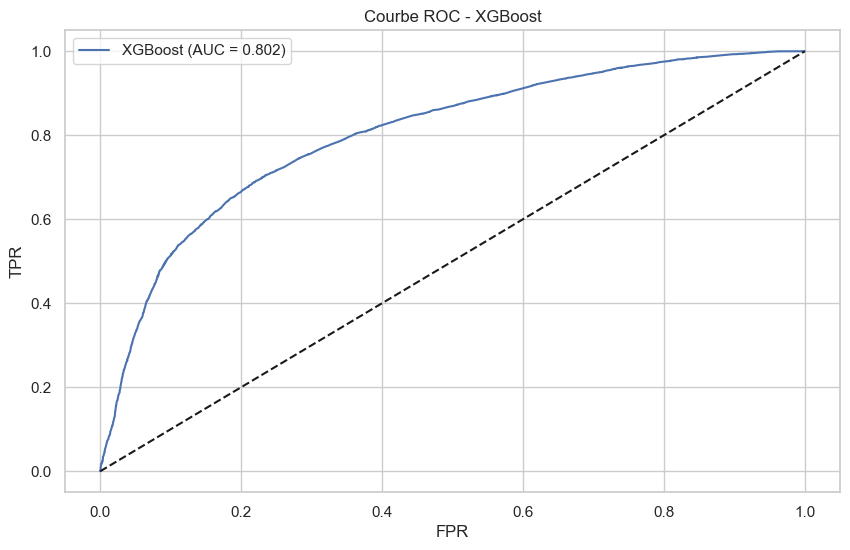

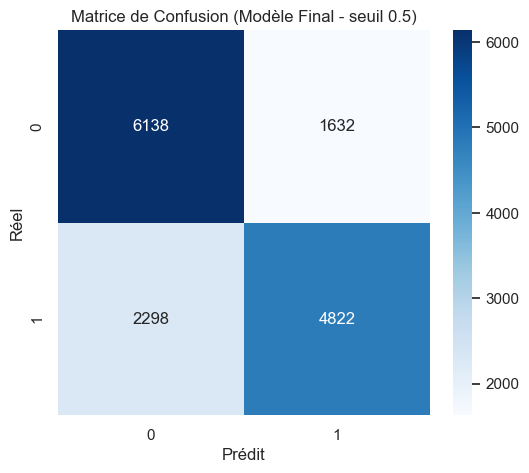

In [ ]:


from xgboost import XGBClassifier


xgb = XGBClassifier(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,#eta
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    #scale_pos_weight=1
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss" #punition pour les erreurs de classification
)

xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("=== XGBOOST - Seuil 0.5 ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Recall (classe 1) :", recall_score(y_test, y_pred_xgb, pos_label=1))
print("ROC-AUC :", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report :")
print(classification_report(y_test, y_pred_xgb))

# Courbe ROC XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbe ROC - XGBoost")
plt.legend()
plt.show()


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion (Modèle Final - seuil 0.5)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()



Comparaison des modéles


=== LogisticRegression - Méthode normale (train/test) ===
Accuracy : 0.7053055742108798
Recall (classe 1) : 0.6178370786516854
ROC-AUC : 0.7699319172704004

=== RandomForest - Méthode normale (train/test) ===
Accuracy : 0.7347212894560108
Recall (classe 1) : 0.6933988764044944
ROC-AUC : 0.7982119720041068

=== XGBoost - Méthode normale (train/test) ===
Accuracy : 0.7360644728005373
Recall (classe 1) : 0.677247191011236
ROC-AUC : 0.8021658225239685


Résumé méthodes normales (train/test) :
               Modèle  Accuracy_holdout  Recall_holdout  ROC_AUC_holdout
0  LogisticRegression          0.705306        0.617837         0.769932
1        RandomForest          0.734721        0.693399         0.798212
2             XGBoost          0.736064        0.677247         0.802166


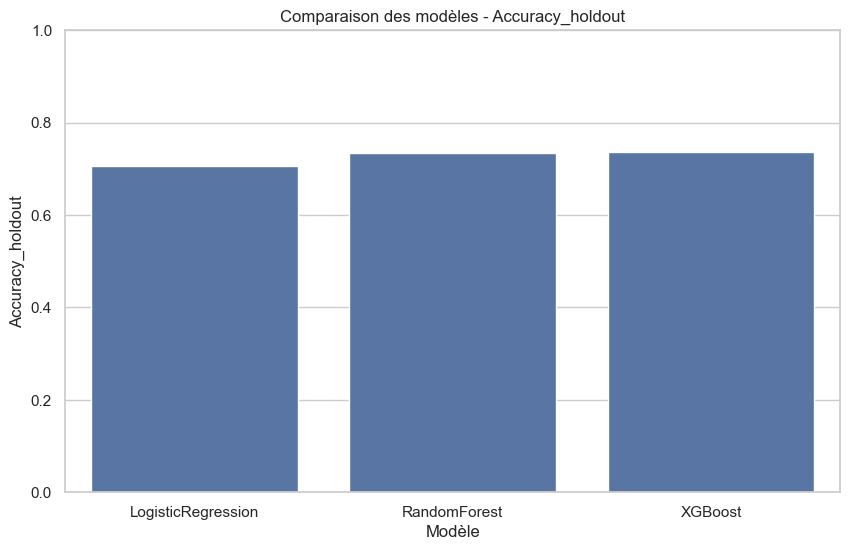

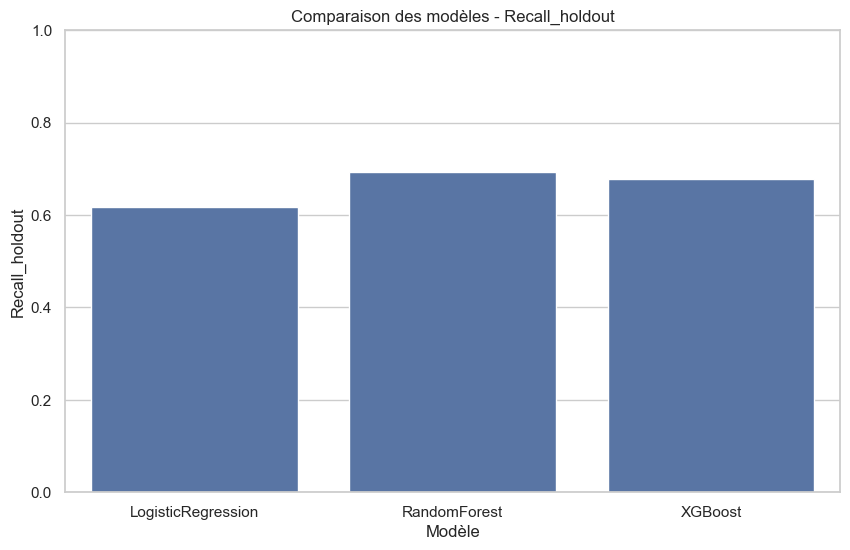

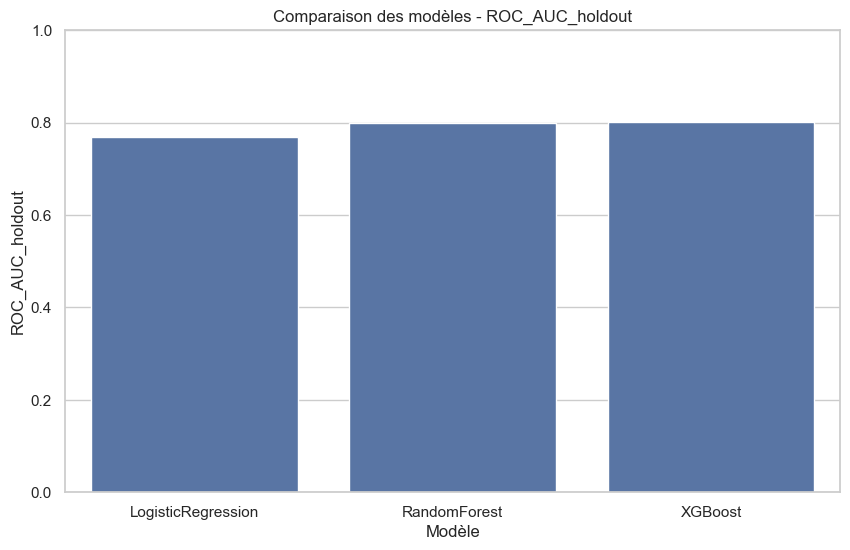

In [60]:
def evaluate_on_holdout(model, name):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {name} - Méthode normale (train/test) ===")
    print("Accuracy :", acc)
    print("Recall (classe 1) :", rec)
    print("ROC-AUC :", auc)

    return {
        "Modèle": name,
        "Accuracy_holdout": acc,
        "Recall_holdout": rec,
        "ROC_AUC_holdout": auc
    }




results_holdout = []
results_holdout.append(evaluate_on_holdout(log_reg, "LogisticRegression"))
results_holdout.append(evaluate_on_holdout(rf, "RandomForest"))
results_holdout.append(evaluate_on_holdout(xgb, "XGBoost"))


df_holdout = pd.DataFrame(results_holdout)
print("\n\nRésumé méthodes normales (train/test) :")
print(df_holdout)

# Visualisation des scores
metrics = ["Accuracy_holdout", "Recall_holdout", "ROC_AUC_holdout"]
for m in metrics:
    plt.figure()
    sns.barplot(x="Modèle", y=m, data=df_holdout)
    plt.ylim(0, 1)
    plt.title(f"Comparaison des modèles - {m}")
    plt.show()


ROC-AUC comparaison graph

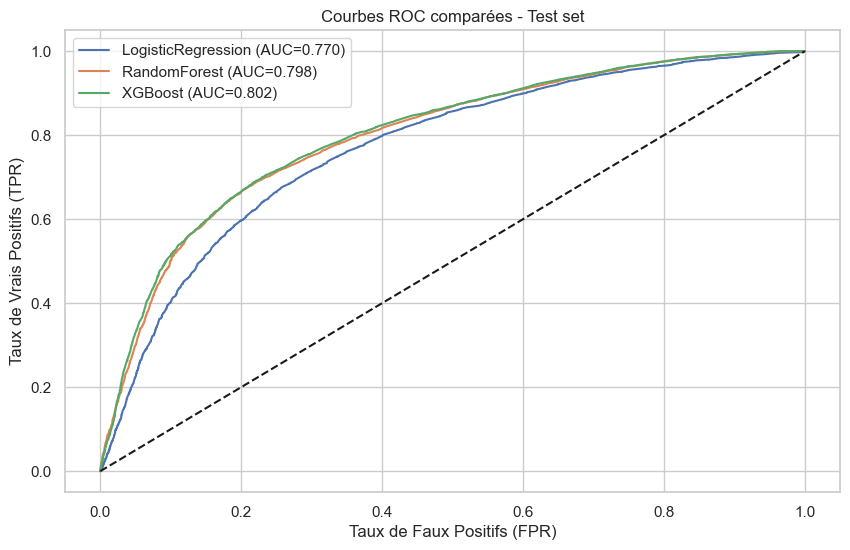

In [61]:
# Courbes ROC pour comparaison visuelle
plt.figure()
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr_lr, tpr_lr, label=f"LogisticRegression (AUC={roc_auc_score(y_test, y_proba):.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})")

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC comparées - Test set")
plt.legend()
plt.show()

### Conclusion
D'aprés une analyse de graphs et resultats obtenu , on peut bien observer que le meilleur model est :<br>
  <span style="display:flex;justify-content:center;font-size:1.5rem;">**`XGBoost`**</span>
qui a les valeurs du scores AUC-ROC et F1 superieurs en les comaparant avec les autres models aperçus dont ils representent des critéres principales dans un dataset de clusterisation 

# Final : Chargement de model

In [ ]:
import joblib
import os
# Créer le dossier 'models' s'il n'existe pas encore
if not os.path.exists('models'):
    os.makedirs('models')
# On sauvegarde le modèle XGBoost entraîné
joblib.dump(xgb, 'models/modele_coeur_xgboost.pkl')

#  On sauvegarde aussi le scaler 
joblib.dump(scaler, 'models/mon_scaler.pkl')

print(" Modèle et Scaler sauvegardés avec succès !")

### **il suffit d'importer le model dans votre application**